## Imports 

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from credit_risk_model.config import DATA_PROCESSED, RESULTS_DIR
import shap
import joblib  
from lime.lime_tabular import LimeTabularExplainer

## Load Data

In [63]:
# Load data
X_train = pd.read_csv(DATA_PROCESSED / "feature_engineered.csv")
X_val = pd.read_csv(DATA_PROCESSED / "feature_engineered_val.csv")
y_val = pd.read_csv(DATA_PROCESSED / "target_val.csv")

# Load model
model = joblib.load("../models/LightGBM.joblib")  
model_features = model.booster_.feature_name()

# Align features
for df in [X_train, X_val]:
    missing = [f for f in model_features if f not in df.columns]
    for f in missing:
        df[f] = 0

X_train = X_train[model_features]
X_val = X_val[model_features]

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")

X_train: (246008, 58), X_val: (61503, 58)


## SHAP

In [64]:
X_sample = X_val.sample(2000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)
print("SHAP values computed")

SHAP values computed


c:\Users\hp\venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


### SHAP summary bar

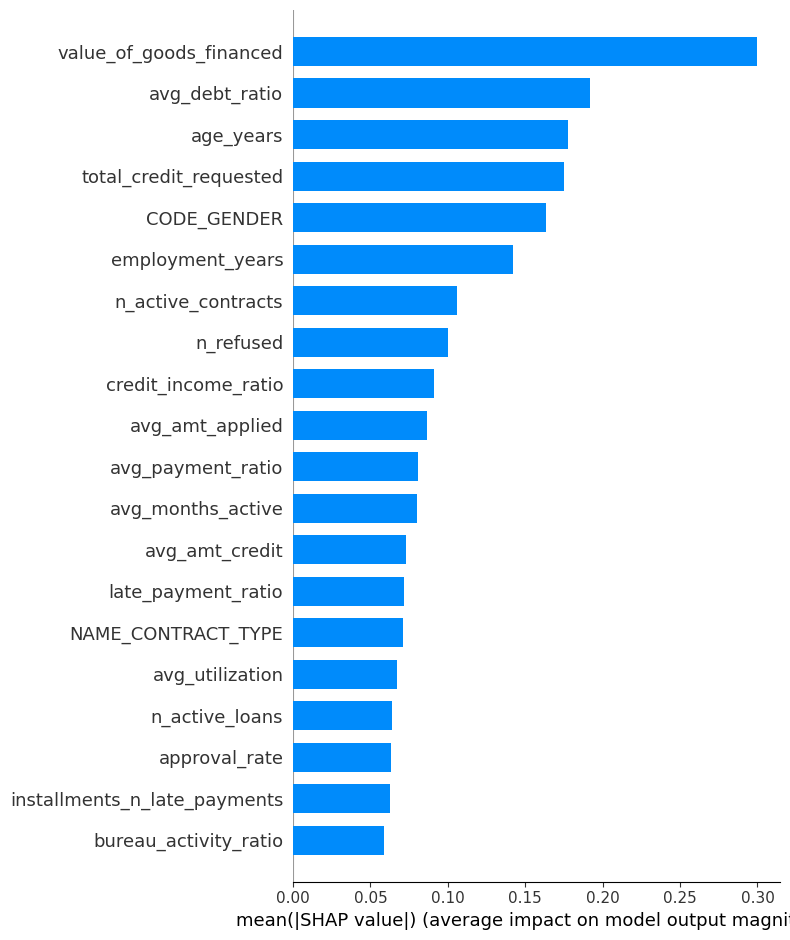

In [70]:
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.savefig(f"{RESULTS_DIR}/explainability/shap_summary_bar.png", dpi=300, bbox_inches="tight")

### SHAP Summary

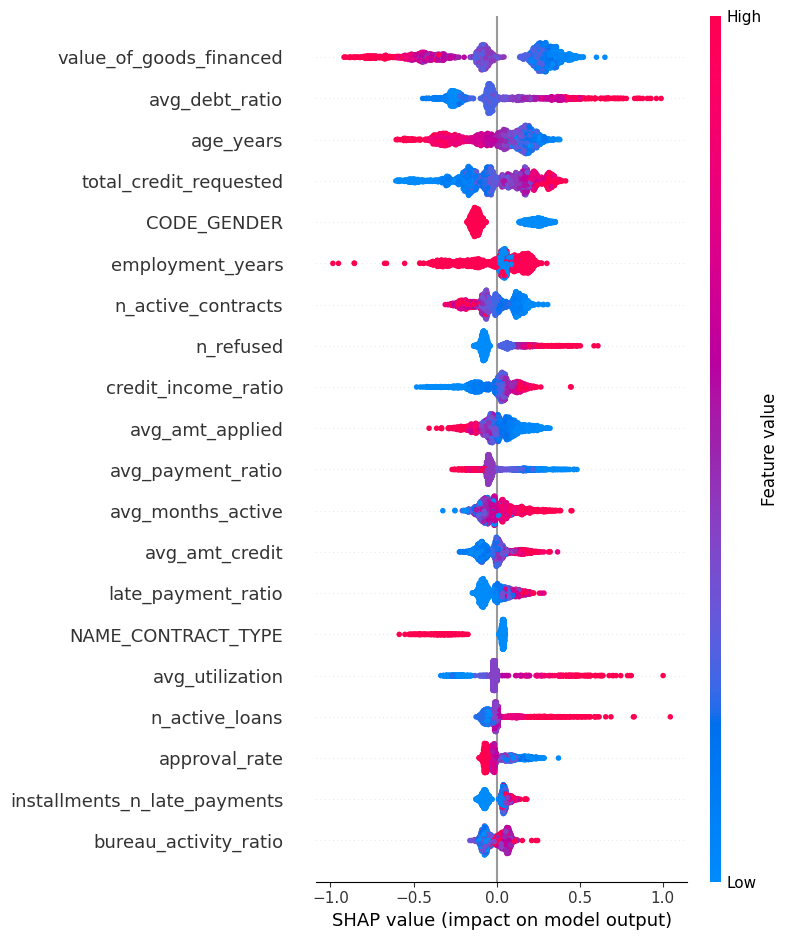

In [71]:
shap.summary_plot(shap_values, X_sample, show=False)
plt.savefig(f"{RESULTS_DIR}/explainability/shap_summary.png", dpi=300, bbox_inches="tight")

###  SHAP Dependence plots

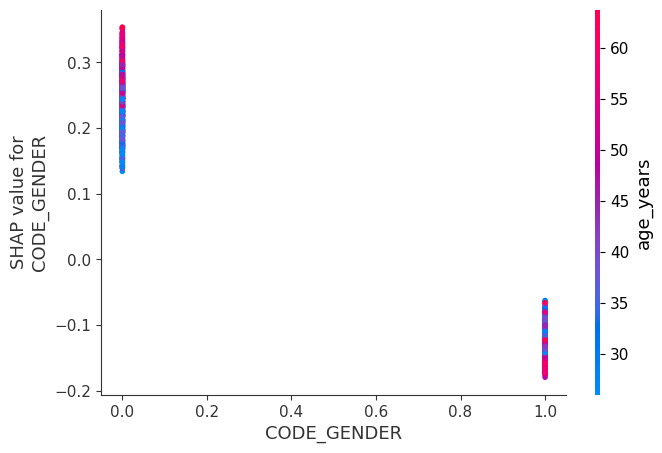

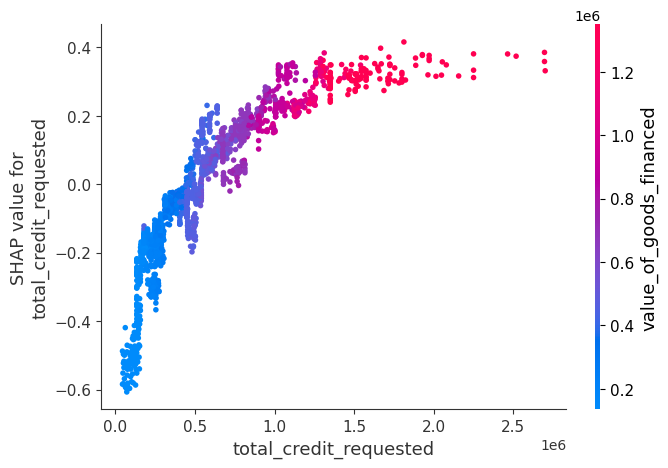

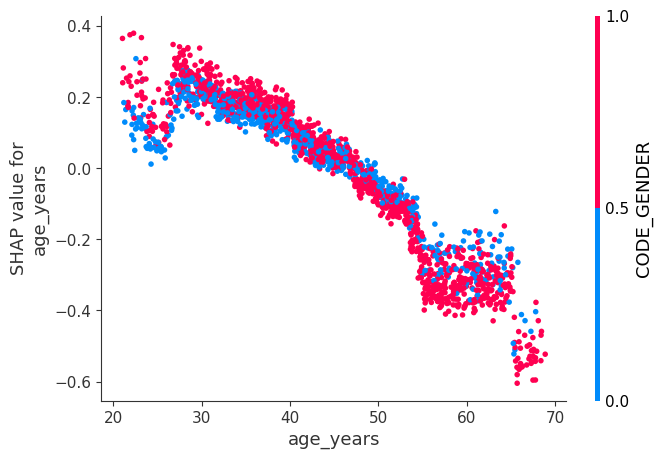

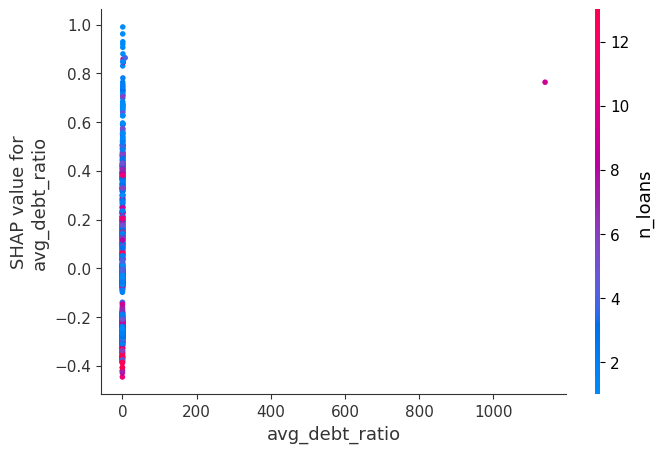

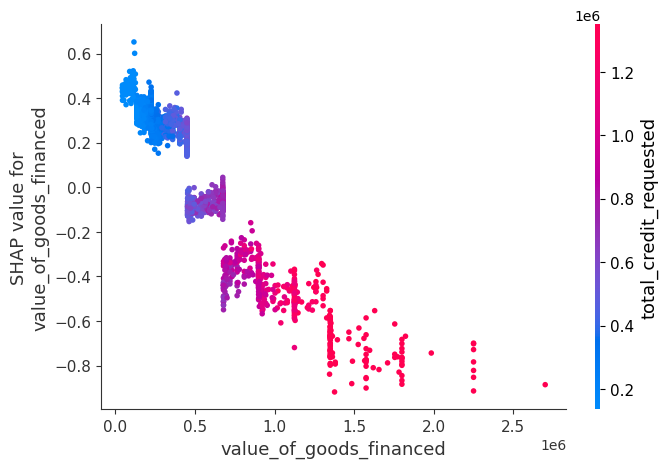

In [72]:
importances = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(importances)[-5:]
top_features = [X_sample.columns[i] for i in top_idx]

for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_sample, show=False)
    plt.savefig(f"{RESULTS_DIR}/explainability/shap_dependence_{feature}.png", dpi=300, bbox_inches="tight")

## LIME Explainability

In [68]:
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=["Non-default", "Default"],
    mode="classification",
    discretize_continuous=True
)

y_proba_val = model.predict_proba(X_val)[:, 1]
high_risk_indices = np.argsort(y_proba_val)[-3:]
print(f"Explaining instances: {high_risk_indices}")

Explaining instances: [60346 49848   301]


#### Explain a multiple samples

c:\Users\hp\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LIME 0: Instance 60346
True label: 1
Predicted prob: 0.646


c:\Users\hp\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LIME 1: Instance 49848
True label: 0
Predicted prob: 0.653


c:\Users\hp\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LIME 2: Instance 301
True label: 1
Predicted prob: 0.791


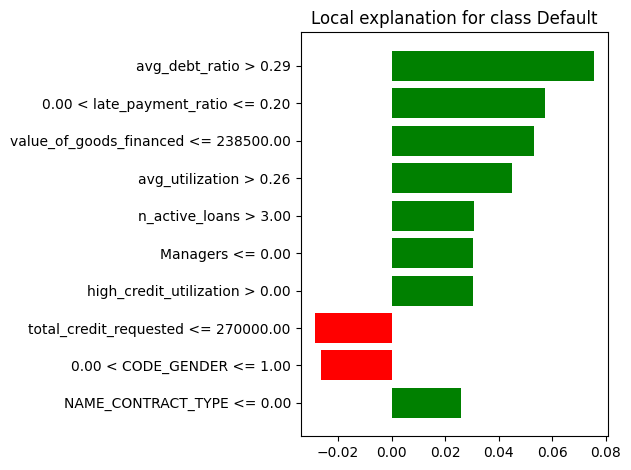

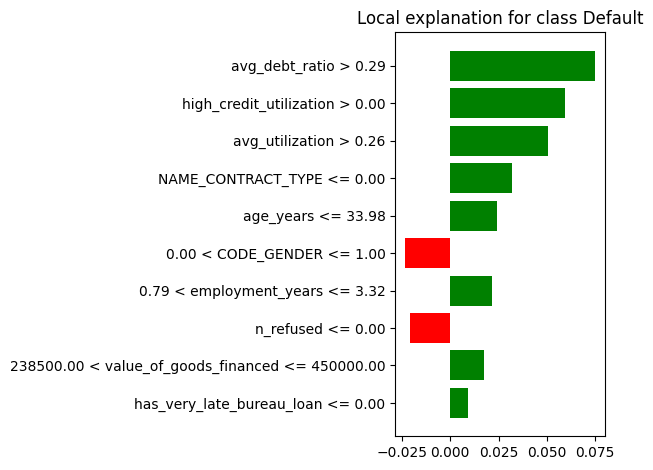

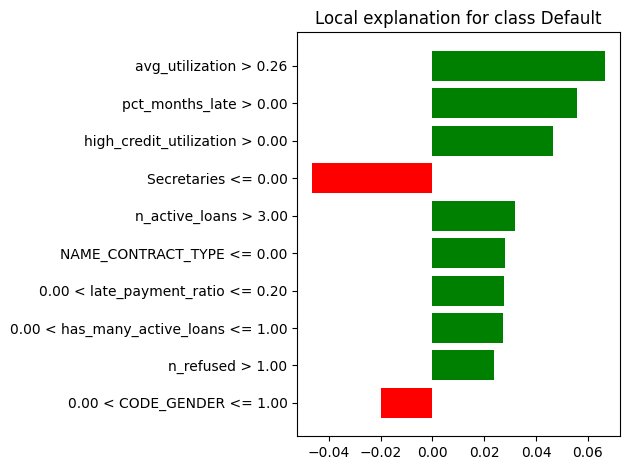

In [69]:
for i, idx in enumerate(high_risk_indices):
    instance = X_val.iloc[idx].values
    
    exp = lime_explainer.explain_instance(
        instance,
        model.predict_proba,
        num_features=10,
        num_samples=500
    )
    
    fig = exp.as_pyplot_figure()
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/explainability/lime_{i}.png", dpi=300, bbox_inches="tight")
    
    
    print(f"\nLIME {i}: Instance {idx}")
    print(f"True label: {y_val.iloc[idx].values[0]}")
    print(f"Predicted prob: {y_proba_val[idx]:.3f}")